# Traffic Volume Flow

Written by: Marshall Mykietyshyn

Data hosted on [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

The purpose of this notebook is to predict the traffic flow at a particular point of an interstate highway. The data was recorded hourly on highway I-94 between Minneapolis and St. Paul, Minnesota over a six year period. It contains both numerical and categorical features, with a target variable counting the number of cars passing a point each hour. Descriptions and ranges of the features are given below.

1. holiday (categorical) - national and regional holidays: either None or name of holiday
2. temp (numerical continuous) - average temperature over the course of the hour (Kelvin): 0.00 to 310.07
3. rain_1h (numerical continuous) - rain that fell during the hour (mm): 0.0 to 9831.3
4. snow_1h (numerical continuous) - amount of snow accumulated during the hour (mm): 0.0 to 0.51
5. clouds_all (numerical discrete) - percentage of cloud cover (%): 0 to 100
6. weather_main (categorical) - short description of weather for the hour: eg. 'sunny' or 'rainy'
7. weather_description (categorical) - more detailed description of the weather: 7.9 to 860.6
8. date_time (date/time) - the date and time of day the data was measured: 0.0 to 56.10
9. traffic_volume (numerical discrete) - number of cars passing point of interest (target variable): 0 to 7280


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from my_regression import whitening_transform, BinaryEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate
from lazypredict.Supervised import LazyRegressor


In [2]:
def CyclicalEncoder(data, col_ls):
    """ Encodes cyclical categorical data as continuous sine and cosine values.
    
    Categorical data needs to be encoded such that it is usable by ML algorithms.
    However, encoding data that has a meaningful cyclical order (often temporal
    data) using normal encoding methods causes it to lose the hierarchichal
    information contained within it. Therefore, encoding the data as a series of
    sine and cosine values allows one to maintain this information, for use in
    machine learning models.
    
    This method adds two columns to the data, one for each of the sine and cosine
    values. The columns are concatenated and returned.
    
    This function requires that the categorical data has already been converted
    to be represented by a range of ints, and scaled to the range [0, 1].
    
    Paramters
        data: DataFrame = all data
        col_ls: list = list of column names to be encoded
        
    Returns
        cyc_data: DataFrame = cyclical data encoded columns
        n_enc_col: int = total number of encoded columns in output
    """
    
    n_enc_col = 0
    for i, col in enumerate(col_ls):
        # Each cyclical column produces two encoded columns
        n_enc_col += 2
        
        # Calculate the encoding for each cyclical period
        cyc_enc = np.zeros((len(data), 2))
        zero_inds = list(data.loc[data[col] == 0].index + 1) + [None]
        last_ind = 0
        for this_ind in zero_inds:
            period = data[col].iloc[last_ind:this_ind].values
            norm_period = period / (period.max() + 1) * 2 * np.pi
            cyc_enc[last_ind:this_ind, 0] = np.cos(norm_period)
            cyc_enc[last_ind:this_ind, 1] = np.sin(norm_period)
            last_ind = this_ind
        
        # Assign new column names
        col_names = [col + '_cos', col + '_sin']
        
        # Concatenate the encoded columns
        if i == 0:
            cyc_data = pd.DataFrame(cyc_enc, columns=col_names)
        else:
            cyc_data = pd.concat([pd.DataFrame(cyc_enc, columns=col_names), cyc_data], axis=1)
        
    return cyc_data, n_enc_col


## Data Preprocessing

- Standard checks for NaNs and missing values
- Had to take care of some suspicious values in "rain_1h" and "snow_1h". Dropped "snow_1h" feature due to the high likelihood that there are errors in recording these values (only days with recorded snow are a span of about 2 weeks). 
- Perhaps drop the rain category as well, since it has so many zeros
- Detailed weather descriptions do not seem to provide more information than could be gleaned from the simple description plus the weather data. Therefore, dropped the feature.
- Holidays only marked at midnight hour (needed to expand to fill all hours of day)
- Added "hour" and "day of year" categorical features, derived from date_time. 
- Only contains data for the first half of 2014 and last half of 2015 (about a year is missing)
- Encoded all categorical features (either cyclical or binary)


In [3]:
# Load an look at overview of data
data = pd.read_csv('data/Metro_Interstate_Traffic_Volume.csv')

# Drop the longer weather descriptions
data.drop(columns=['weather_description'], inplace=True)

# Convert the date-time column to the proper format
data.date_time = pd.to_datetime(data.date_time)

# Display the data and its summary statistics
display(data.head(n=5))
display(data.describe())


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
0,None,288.28,0.00,0.00,40,Clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.00,0.00,75,Clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.00,0.00,90,Clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.00,0.00,90,Clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.00,0.00,75,Clouds,2012-10-02 13:00:00,4918


,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.00,48204.00,48204.00,48204.00,48204.00
mean,281.21,0.33,0.00,49.36,3259.82
std,13.34,44.79,0.01,39.02,1986.86
min,0.00,0.00,0.00,0.00,0.00
25%,272.16,0.00,0.00,1.00,1193.00
50%,282.45,0.00,0.00,64.00,3380.00
75%,291.81,0.00,0.00,90.00,4933.00
max,310.07,9831.30,0.51,100.00,7280.00


In [4]:
# Check for NaNs
data.isna().sum()


holiday           0
temp              0
rain_1h           0
snow_1h           0
clouds_all        0
weather_main      0
date_time         0
traffic_volume    0
dtype: int64

In [5]:
# Check for non-numerical values in numerical columns
data.applymap(np.isreal).sum()


holiday               0
temp              48204
rain_1h           48204
snow_1h           48204
clouds_all        48204
weather_main          0
date_time         48204
traffic_volume    48204
dtype: int64

## Suspicious values

The temperatures are in Kelvin, where 0K corresponds to absolute zero = -273.15C. Therefore, the min temperature of 0K is highly suspicious. After looking at the data, it was found that no reasonable temperature was recorded for two short intervals. Since the intervals are relatively short (4 and 6 hours respectively) and the temperature before and after the intervals are roughly similar, the temperatures can be imputed using simple linear interpolation. This is done to maintain the continuity of the temporal data.

Additionally, the maximum rain and snow values seem off. Nine meters of rain is a ridiculous amount to fall in one hour. Luckily, this seems to simply be an anomaly, as there is only one entry with greater than 100mm of rainfall. All weather data for Minneapolis-St. Paul on this date indicates trace rainfall (for example [here](https://www.dnr.state.mn.us/climate/historical/daily-data.html?sid=mspthr&sname=Minneapolis/St%20Paul%20Threaded%20Record&sdate=2010-01-01&edate=por) and [here](https://www.weather.gov/media/mpx/Climate/MSP/jul2016.pdf)), so this entry will be divided by 10000, to make the rainfall less than 1mm. 

All of the nonzero snowfall values occur in the date range 23.12.2015-08.01.2016, and there are only 63 entries where any snowfall is recorded Furthermore, many of these seem to be duplicate entries, where there are multiple entries for the same hour. This is obviously wrong, and it can be shown by a quick check of the [weather data](https://www.dnr.state.mn.us/climate/historical/daily-data.html?sid=mspthr&sname=Minneapolis/St%20Paul%20Threaded%20Record&sdate=2010-01-01&edate=por), where one can find entries as great as 16.3" (41.4mm) for a single day. Therefore, it does not seem that snowfall is a reliable feature, and will be dropped from the data.

Lastly, as found during this analysis, there are duplicate entries for individual hours. These seem to be associated with multiple weather_main categories for a single hour, likely meaning the weather in that hour could not be described by a single category.  If left, these would bias the data. Therefore, these must be handled by selecting a single weather description for each hour. It does not seem that the order of descriptions is systematic. Therefore, using pandas built-in drop duplicates function, where the first of the duplicated entries is kept, should be a sufficient way to handle this.


In [6]:
# Check suspicious min temp rows (-40C = 233K)
display(data.loc[data.temp < 233])


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
11898,None,0.00,0.00,0.00,0,Clear,2014-01-31 03:00:00,361
11899,None,0.00,0.00,0.00,0,Clear,2014-01-31 04:00:00,734
11900,None,0.00,0.00,0.00,0,Clear,2014-01-31 05:00:00,2557
11901,None,0.00,0.00,0.00,0,Clear,2014-01-31 06:00:00,5150
11946,None,0.00,0.00,0.00,0,Clear,2014-02-02 03:00:00,291
11947,None,0.00,0.00,0.00,0,Clear,2014-02-02 04:00:00,284
11948,None,0.00,0.00,0.00,0,Clear,2014-02-02 05:00:00,434
11949,None,0.00,0.00,0.00,0,Clear,2014-02-02 06:00:00,739
11950,None,0.00,0.00,0.00,0,Clear,2014-02-02 07:00:00,962
11951,None,0.00,0.00,0.00,0,Clear,2014-02-02 08:00:00,1670


In [7]:
# Split the data into continuous blocks of 0 Kelvin data points
too_low_temps = data.loc[data.temp < 233].index.values
jumps = np.where(np.diff(too_low_temps) > 1)[0] + 1
ind_pairs = []
missing_ranges = []
last_ind = 0
for ind in jumps:
    missing_ranges.append(too_low_temps[last_ind:ind])
    last_ind = ind
missing_ranges.append(too_low_temps[last_ind:])

# # Display the data points before and after the missing temperatures
# for temp_range in missing_ranges:
#     inds = np.arange(temp_range[0] - 1, temp_range[-1] + 2)
#     display(data.iloc[inds, :])
    

In [8]:
# Interpolate through the block
for temp_inds in missing_ranges:
    t1 = data.temp.iloc[temp_inds[0] - 1]
    t2 = data.temp.iloc[temp_inds[-1] + 1]
    new_temps = np.linspace(t1, t2, len(temp_inds) + 2)[1:-1]
    data.temp.iloc[temp_inds] = new_temps

# # Display the data points before and after the missing temperatures
# for temp_range in missing_ranges:
#     inds = np.arange(temp_range[0] - 1, temp_range[-1] + 2)
#     display(data.iloc[inds, :])


In [9]:
# Check high rain volume rows
display(data.loc[data.rain_1h > 100])

# Divide the value such that it is less than 1mm
rain_ind = data.loc[data.rain_1h > 100].index.values
data.rain_1h.iloc[rain_ind] /= 1e4
display(data.iloc[rain_ind, :])


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
24872,None,302.11,9831.30,0.00,75,Rain,2016-07-11 17:00:00,5535


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
24872,None,302.11,0.98,0.00,75,Rain,2016-07-11 17:00:00,5535


In [10]:
# Check low snow fall depths
display(data.loc[data.snow_1h > 0])
data.drop(columns=['snow_1h'], inplace=True)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
20158,None,274.33,0.98,0.51,90,Rain,2015-12-23 12:00:00,5167
20159,None,274.33,0.98,0.51,90,Snow,2015-12-23 12:00:00,5167
20160,None,274.33,0.98,0.51,90,Mist,2015-12-23 12:00:00,5167
20161,None,274.33,0.98,0.51,90,Fog,2015-12-23 12:00:00,5167
20162,None,273.74,0.00,0.32,90,Snow,2015-12-23 14:00:00,5182
...,...,...,...,...,...,...,...,...
20494,None,273.22,0.00,0.08,90,Mist,2016-01-08 03:00:00,401
20507,None,273.80,0.00,0.25,90,Snow,2016-01-08 13:00:00,4933
20508,None,273.80,0.00,0.25,90,Mist,2016-01-08 13:00:00,4933
20509,None,273.67,0.00,0.13,90,Snow,2016-01-08 15:00:00,5548


In [11]:
# Drop the entries where there are multiple rows for the same hour
display(len(data[data.date_time.duplicated()]))
clean_data = data.drop_duplicates(subset='date_time')
clean_data = clean_data.reset_index(drop=True)
display(len(clean_data))


7629

40575

In [12]:
# Look at the stats again
display(clean_data.describe())


,temp,rain_1h,clouds_all,traffic_volume
count,40575.00,40575.00,40575.00,40575.00
mean,281.38,0.08,44.20,3290.65
std,13.10,0.77,38.68,1984.77
min,243.39,0.00,0.00,0.00
25%,271.84,0.00,1.00,1248.50
50%,282.86,0.00,40.00,3427.00
75%,292.28,0.00,90.00,4952.00
max,310.07,55.63,100.00,7280.00


In [13]:
# Generate new columns for hour and day of the year
clean_data['hour'] = clean_data.date_time.dt.hour
# clean_data['day_of_year'] = clean_data.date_time.dt.dayofyear - 1 + (data.hour / 24)
clean_data['day_of_week'] = clean_data.date_time.dt.dayofweek
clean_data['day_of_year'] = clean_data.date_time.dt.dayofyear - 1
# clean_data['month'] = clean_data.date_time.dt.month
clean_data['year'] = clean_data.date_time.dt.year

# display(clean_data.loc[clean_data.year == 2014])
# display(clean_data.loc[clean_data.year == 2015])
# # display(clean_data.head(n=10))
# display(clean_data.iloc[2102:2105, :])
# display(clean_data.iloc[9396:9399, :])
# display(clean_data.iloc[13897:13900, :])
# display(clean_data.iloc[17490:17493, :])
# display(clean_data.iloc[25328:25331, :])
# display(clean_data.iloc[34041:34044, :])
# display(clean_data.tail(n=10))
# [2104, 9398, 13898, 17492, 25330, 34043]


In [14]:
# Holidays are only marked at midnight, fill other hours of the day
display(len(clean_data.loc[clean_data.holiday != 'None']))
# display(data.loc[data.holiday != 'None'])
day_h = 24
holi_data = clean_data.copy()
holiday_inds = holi_data.loc[holi_data.holiday != 'None'].index
for ind in holiday_inds:
    this_holiday = holi_data.holiday.iloc[ind]
    holi_data.holiday.iloc[ind:ind + day_h] = this_holiday
display(len(holi_data.loc[holi_data.holiday != 'None']))

# Change holiday to a binary value
holi_data.loc[holi_data.holiday != 'None', 'holiday'] = 1
holi_data.loc[holi_data.holiday == 'None', 'holiday'] = 0
holi_data.holiday = pd.to_numeric(holi_data.holiday)
# display(holi_data.head(n=10))


53

1272

In [15]:
# Add a binary weekday category
# df['Price'] = [1500 if x =='Music' else 800 for x in df['Event']]
holi_data['weekday'] = [1 if x < 5 else 0 for x in holi_data.day_of_week]
holi_cols = holi_data.columns.tolist()
holi_cols = holi_cols[-1:] + holi_cols[:-1]
holi_data = holi_data[holi_cols]


In [16]:
# Encode the categorical 'weather_main' feature using binary encoding
cat_cols = ['weather_main']
cat_data, n_cat_col = BinaryEncoder(clean_data, cat_cols)
# display(data.head(n=10))


In [17]:
# Encode the hour and day features using cyclical encoding
cyc_cols = ['hour']
cyc_data, n_cyc_col = CyclicalEncoder(clean_data, cyc_cols)

# Must encode year manually due to missing data
day_enc = np.zeros((len(clean_data), 2))
year_inds = list(np.where(np.diff(clean_data.year) > 0)[0] + 1) + [None]
p_max = [366, 365, 365, 365, 366, 365, 365]
# print(year_inds)
last_ind = 0
for i, this_ind in enumerate(year_inds):
    # print(data.year.iloc[last_ind])
    period = clean_data.day_of_year.iloc[last_ind:this_ind].values
    norm_period = period / p_max[i] * 2 * np.pi
    day_enc[last_ind:this_ind, 0] = np.cos(norm_period)
    day_enc[last_ind:this_ind, 1] = np.sin(norm_period)
    last_ind = this_ind

# Assign new column names
col_names = ['day_of_year_cos', 'day_of_year_sin']
day_data = pd.DataFrame(day_enc, columns=col_names)
n_cyc_col += 2
    
# Concatenate the encoded columns
# data = pd.concat([day_data, cyc_data, data], axis=1)
n_enc_col = n_cat_col + n_cyc_col + 2
# display(data.head(n=10))


In [18]:
# Concatenate the data and drop all the columns that are no longer required
enc_data = pd.concat([day_data, cyc_data, cat_data, holi_data], axis=1)
pp_data = enc_data.drop(columns=cat_cols + cyc_cols + ['date_time', 'day_of_week', 'day_of_year', 'year'])


In [19]:
# Scale the skewed rain feature using a log transform
pp_data['rain_1h'] = np.log(pp_data['rain_1h'] + 1)


In [20]:
# Display the pre-processed data
display(pp_data.head(n=5))
# display(data.head(n=5))
# print(n_enc_col)
# display(pp_data.dtypes)


,day_of_year_cos,day_of_year_sin,hour_cos,hour_sin,weather_main_0,weather_main_1,weather_main_2,weather_main_3,weekday,holiday,temp,rain_1h,clouds_all,traffic_volume
0,0.01,-1.00,-0.71,0.71,0,0,0,1,1,0,288.28,0.00,40,5545
1,0.01,-1.00,-0.87,0.50,0,0,0,1,1,0,289.36,0.00,75,4516
2,0.01,-1.00,-0.97,0.26,0,0,0,1,1,0,289.58,0.00,90,4767
3,0.01,-1.00,-1.00,0.00,0,0,0,1,1,0,290.13,0.00,90,5026
4,0.01,-1.00,-0.97,-0.26,0,0,0,1,1,0,291.14,0.00,75,4918


## Data Visualization and EDA

Characteristics
- No spatial data
- There is temporal data (5 years, not fully continuous)

Ideas
- Look at flow distribution as a function of hour of day
- Look at flow as a function of weather

Takeaways
- People drive mostly during the day, as would be expected. The peak time is rush hour. Also expected
- It doesn't really matter what the weather is, people drive at the same rate no matter the weather (with the exception of squalls, although this could just be a small sample size issue)


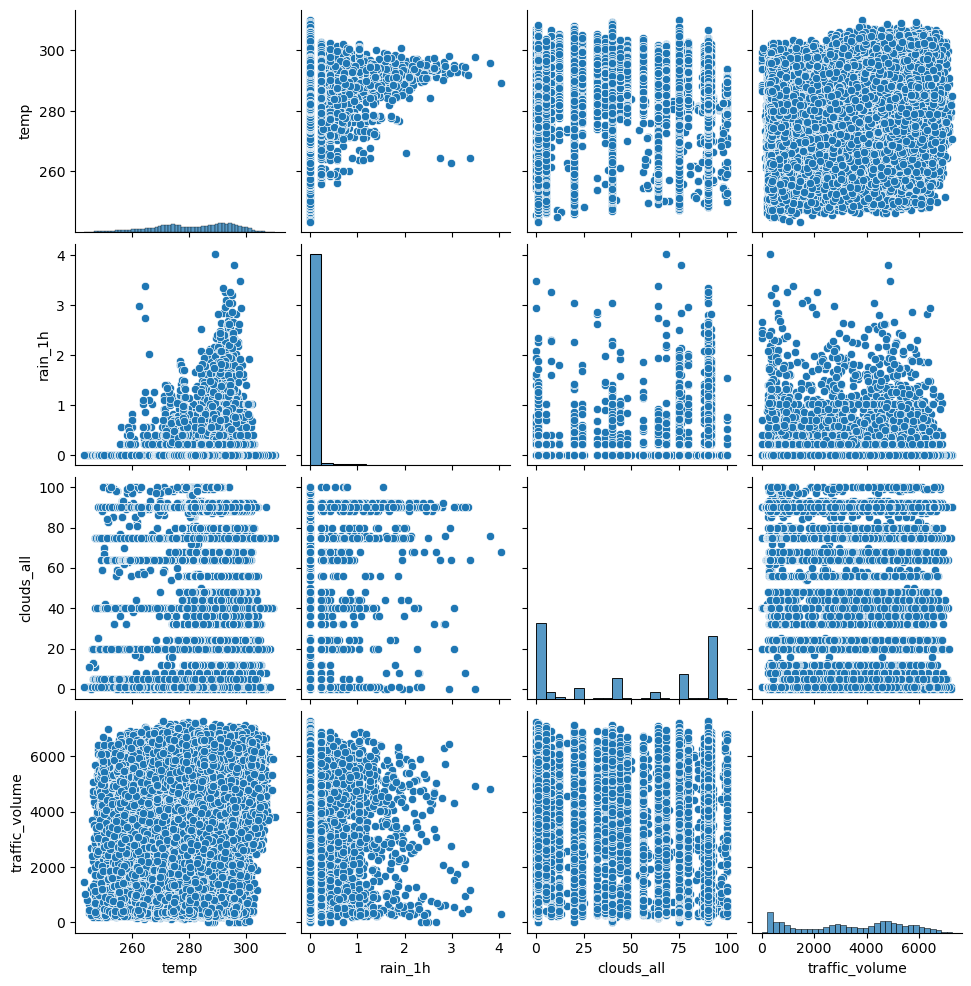

In [21]:
# Visualize the data
sns.pairplot(pp_data.iloc[:, n_enc_col:]);
plt.show()


In [22]:
# # Plot the traffic volume distribution by hour
# m_len = len(clean_data.month.unique())
# # month_vol = np.zeros(m_len)
# month_vol_avg = np.zeros(m_len)
# month_vol_std = np.zeros_like(month_vol_avg)
# for i in range(m_len):
#     # month_vol[i] = clean_data.loc[clean_data.month == i, 'traffic_volume'].sum()
#     month_vol_avg[i] = clean_data.loc[clean_data.month == i, 'traffic_volume'].mean()
#     month_vol_std[i] = clean_data.loc[clean_data.month == i, 'traffic_volume'].std()

# fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# # ax.bar(np.arange(m_len), hour_vol)
# ax.bar(np.arange(m_len), month_vol_avg)
# ax.errorbar(np.arange(m_len), month_vol_avg, month_vol_std, color='k', capsize=5, ls='none')
# ax.set_xlabel('Month', fontsize=12)
# ax.set_ylabel('Total Traffic Flow (Count)', fontsize=12)
# ax.set_xticks(np.arange(m_len)[::2])
# plt.show()


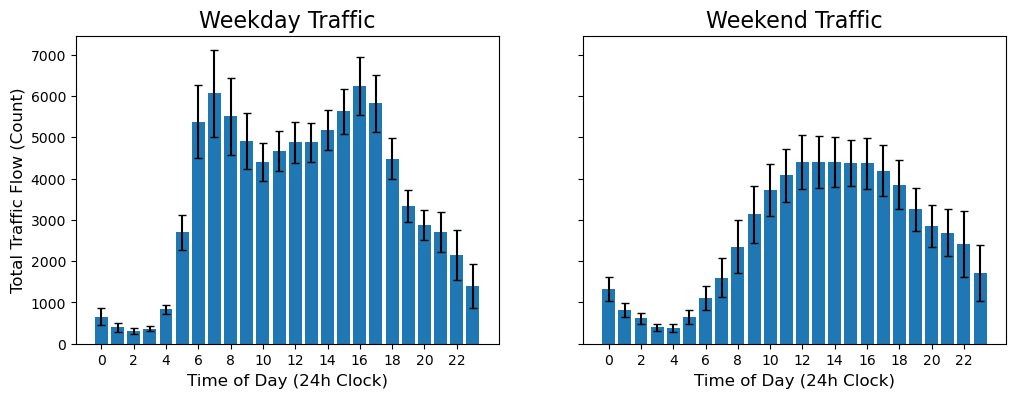

In [23]:
# Plot the traffic volume distribution by hour, and separated by weekday/weekend
h_len = len(clean_data.hour.unique())
weekday_data = holi_data.loc[holi_data.weekday == 1]
# display(weekday_data.head(n=5))
weekend_data = holi_data.loc[holi_data.weekday == 0]
hour_vol_data = [weekday_data, weekend_data]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
title_ls = ['Weekday', 'Weekend']
for j, tmp_data in enumerate(hour_vol_data):
    hour_vol_avg = np.zeros(h_len)
    hour_vol_std = np.zeros_like(hour_vol_avg)
    for i in range(h_len):
        hour_vol_avg[i] = tmp_data.loc[tmp_data.hour == i, 'traffic_volume'].mean()
        hour_vol_std[i] = tmp_data.loc[tmp_data.hour == i, 'traffic_volume'].std()

    axes[j].bar(np.arange(h_len), hour_vol_avg)
    axes[j].errorbar(np.arange(h_len), hour_vol_avg, hour_vol_std, color='k', capsize=3, ls='none')
    axes[j].set_xlabel('Time of Day (24h Clock)', fontsize=12)
    axes[j].set_title(f'{title_ls[j]} Traffic', fontsize=16)
    axes[j].set_xticks(np.arange(h_len)[::2])
axes[0].set_ylabel('Total Traffic Flow (Count)', fontsize=12)
plt.show()


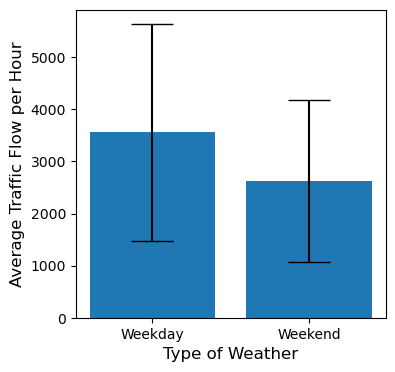

In [24]:
# Look at average traffic volume divided by weekday vs. weekend
weekday_end_vol_avg = np.zeros(2)
weekday_end_vol_std = np.zeros_like(weekday_end_vol_avg)
for i in range(weekday_end_vol_avg.size):
    weekday_end_vol_avg[i] = hour_vol_data[i].traffic_volume.mean()
    weekday_end_vol_std[i] = hour_vol_data[i].traffic_volume.std()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.bar(np.arange(2), weekday_end_vol_avg)
ax.errorbar(np.arange(2), weekday_end_vol_avg, weekday_end_vol_std, color='k', capsize=15, ls='none')
ax.set_xlabel('Type of Weather', fontsize=12)
ax.set_ylabel('Average Traffic Flow per Hour', fontsize=12)
ax.set_xticks(np.arange(2))
# ax.set_xticklabels(title_ls, rotation=45, ha='right')
ax.set_xticklabels(title_ls)
plt.show()


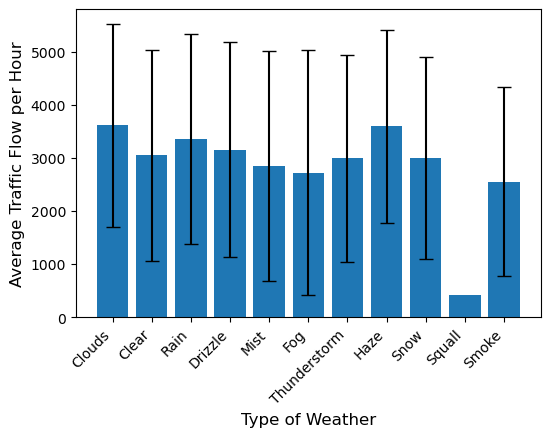

In [25]:
# Plot traffic flow as a function of weather
weather_types = list(clean_data.weather_main.unique())
# print(weather_types)
weather_vol_avg = np.zeros(len(weather_types))
weather_vol_std = np.zeros_like(weather_vol_avg)
for i, weather in enumerate(weather_types):
    # weather_inds = clean_data.loc[clean_data.weather_main == weather].index
    # n_instances = weather_inds.values.size
    # weather_vol[i] = clean_data.traffic_volume.iloc[weather_inds].sum() / n_instances
    # weather_vol[i] = clean_data.traffic_volume.iloc[weather_inds].mean()
    weather_vol_avg[i] = clean_data.loc[clean_data.weather_main == weather, 'traffic_volume'].mean()
    weather_vol_std[i] = clean_data.loc[clean_data.weather_main == weather, 'traffic_volume'].std()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.bar(np.arange(len(weather_types)), weather_vol_avg)
ax.errorbar(np.arange(len(weather_types)), weather_vol_avg, weather_vol_std, color='k', capsize=5, ls='none')
ax.set_xlabel('Type of Weather', fontsize=12)
ax.set_ylabel('Average Traffic Flow per Hour', fontsize=12)
ax.set_xticks(np.arange(len(weather_types)))
ax.set_xticklabels(weather_types, rotation=45, ha='right')
plt.show()


## Machine Learning

- Split into train and test: try shuffled and unshuffled (leave out one year)
- Try whitening the numerical data (should I whiten it?)
- 


In [26]:
# Split into train and test sets

In [ ]:
# Whiten the data

In [ ]:
# # Define a grid search to train and test the model
# cv_split = ShuffleSplit(n_splits=10, test_size=0.2, random_state=66)

# # Random forest regressor
# d_forest_reg = {'name': 'Random Forest',
#                 'model': RandomForestRegressor(random_state=66, warm_start=True),
#                 'params': {'n_estimators': [100, 200, 400, 800],
#                            'max_depth': [1, 2, 4],
#                            'min_samples_leaf': [1, 5, 10],
#                            'ccp_alpha': [0., 0.0005]}}
# d_forest_reg['grid'] = GridSearchCV(d_forest_reg['model'], d_forest_reg['params'], scoring='r2', n_jobs=-1, cv=cv_split)

# # SVR
# d_svr = {'name': 'SVR',
#          'model': SVR(),
#          'params': {'kernel': ['rbf'],
#                     'gamma': [1, 10, 100],
#                     'C': [10, 100, 500],
#                     'epsilon': [0.1, 0.5, 1]}}
# d_svr['grid'] = GridSearchCV(d_svr['model'], d_svr['params'], scoring='r2', n_jobs=-1, cv=cv_split)

# # XGBoost
# d_xgb = {'name': 'XGBoost',
#          'model': XGBRegressor(gamma=10, reg_lambda=100),
#          'params': {'n_estimators': [100, 200, 400, 800],
#                     'eta': [0.1, 0.3],
#                     'max_depth': [1, 5, 10],
#                     'alpha': [0, 1, 10]}}
# d_xgb['grid'] = GridSearchCV(d_xgb['model'], d_xgb['params'], scoring='r2', n_jobs=-1, cv=cv_split)

# # Assign the models to a list
# reg_models = [d_forest_reg, d_svr, d_xgb]


In [ ]:
# # Fit the models and check the performance
# for cat_model in cat_models:
#     # Find the best model
#     grid_search = cat_model['grid']
#     grid_search.fit(cat_X_white_train, cat_y_train)
#     print('done search')
        
#     # Save the results
#     cat_model['best_params'] = grid_search.best_params_
#     cat_model['best_model'] = grid_search.best_estimator_
#     cat_model['train_scores'] = grid_search.best_score_
    
#     # Check the model accuracy
#     cat_model['best_model'].fit(cat_X_white_train, cat_y_train)
#     cat_model['accuracy'] = cat_model['best_model'].score(cat_X_white_test, cat_y_test)
#     cat_model['y_pred'] = cat_model['best_model'].predict(cat_X_white_test)
#     m_name = cat_model['name']
#     m_acc = cat_model['accuracy']
#     print(f'The {m_name} model accuracy is: {m_acc:3.2f}')
#     # print(f'The {cat_model['name']} model accuracy is: {cat_model['accuracy']:3.2f}')


## Deep Learning

Try a neural network to see if I can get improved performance
